# 2.1 VGG-data balanced&enhanced-class

Original class distribution: Counter({5: 10300, 4: 3618, 1: 2658, 2: 2099, 0: 694, 6: 502, 7: 202, 3: 191})
Balanced class distribution: Counter({5: 8240, 4: 3618, 1: 2658, 2: 2099, 6: 2000, 0: 2000, 3: 2000, 7: 2000})
Original training set distribution:
5    10300
4     3618
1     2658
2     2099
0      694
6      502
7      202
3      191
Name: count, dtype: int64

Balanced training set distribution:
5    8240
4    3618
1    2658
2    2099
6    2000
0    2000
3    2000
7    2000
Name: count, dtype: int64

Test set distribution:
5    2575
4     904
1     665
2     525
0     173
6     126
7      51
3      48
Name: count, dtype: int64
Epoch 1/30
769/769 ━━━━━━━━━━━━━━━━━━━━ 141s 98ms/step - accuracy: 0.3978 - loss: 2.6893 - val_accuracy: 0.5651 - val_loss: 1.2726 - learning_rate: 0.0010
Epoch 2/30
769/769 ━━━━━━━━━━━━━━━━━━━━ 139s 97ms/step - accuracy: 0.5179 - loss: 1.2806 - val_accuracy: 0.6127 - val_loss: 1.1017 - learning_rate: 0.0010
Epoch 3/30
769/769 ━━━━━━━━━━━━━━━━━━━━ 139s 97m

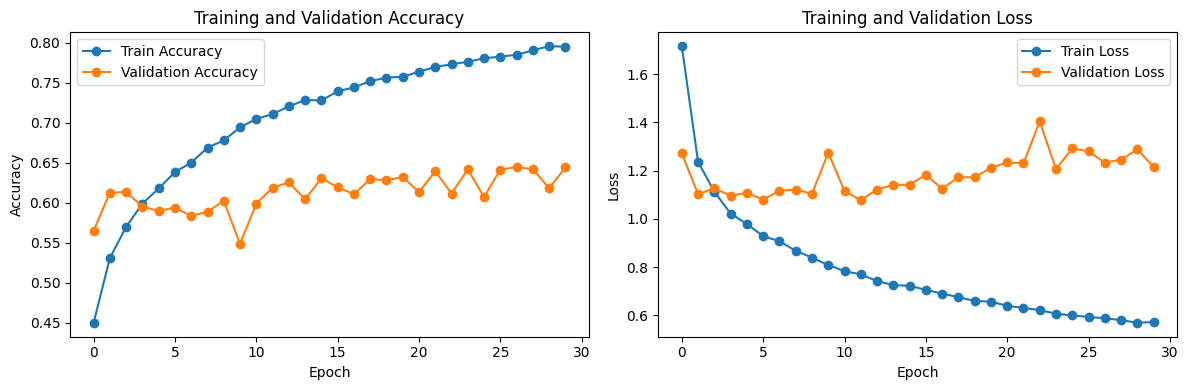

In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

csv_file_path = '/content/drive/MyDrive/9444 project_VGG/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/9444 project_VGG/ISIC_2019_Training_Input'

# 读取数据
data = pd.read_csv(csv_file_path)
image_files = data['image'].values
labels = data.drop(['image', 'UNK'], axis=1)

# 将多标签转换为单标签
label_names = labels.idxmax(axis=1).astype(str)

# 编码标签为整数
label_encoder = LabelEncoder()
label_names_encoded = label_encoder.fit_transform(label_names)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    image_files, label_names_encoded, test_size=0.2, random_state=42, stratify=label_names_encoded)

# 从训练集中抽样子集
subset_size = 10000  # 你可以根据计算资源调整子集大小
subset_indices = np.random.choice(len(X_train), size=subset_size, replace=False)
X_train_subset = X_train[subset_indices]
y_train_subset = y_train[subset_indices]

# 计算类别分布
class_counts = Counter(y_train_subset)
print("Original class distribution:", class_counts)

# 设置最小和最大样本数
min_samples = 2000
max_samples = 5000

# 安全的数据增强函数
def augment_image(image):
    # 随机旋转180度
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32) * 2)

    # 随机缩放
    scale = tf.random.uniform(shape=[], minval=0.8, maxval=1.2)
    new_height = tf.cast(224 * scale, tf.int32)
    new_width = tf.cast(224 * scale, tf.int32)
    image = tf.image.resize(image, [new_height, new_width])
    image = tf.image.resize_with_crop_or_pad(image, 224, 224)

    # 随机调整对比度
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image

# 图像加载和预处理函数
def load_and_preprocess_image(file_path):
    try:
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = tf.keras.applications.vgg16.preprocess_input(image)
        return image
    except tf.errors.InvalidArgumentError as e:
        print(f"Cannot read image {file_path}: {e}")
        return None

# 灵活重采样和数据增强
X_resampled = []
y_resampled = []

for label, count in class_counts.items():
    X_class = X_train_subset[y_train_subset == label]

    if count < min_samples:
        # 对少数类进行过采样和增强
        n_samples = min(max_samples, max(min_samples, count * 2))
        n_augment = n_samples - count

        for file in X_class:
            X_resampled.append(file)
            y_resampled.append(label)

        for _ in range(n_augment):
            file = np.random.choice(X_class)
            X_resampled.append(file)
            y_resampled.append(label)

    elif count > max_samples:
        # 对多数类进行欠采样
        n_samples = max(min_samples, int(count * 0.8))  # 减少20%，但不少于最小样本数
        sampled_files = np.random.choice(X_class, n_samples, replace=False)
        X_resampled.extend(sampled_files)
        y_resampled.extend([label] * n_samples)

    else:
        X_resampled.extend(X_class)
        y_resampled.extend([label] * count)

# 将列表转换为numpy数组
X_train_balanced = np.array(X_resampled)
y_train_balanced = np.array(y_resampled)

print("Balanced class distribution:", Counter(y_train_balanced))

# 数据集创建函数
def create_dataset(image_files, labels, image_dir, batch_size=32, is_training=True):
    def process_path(file_path, label):
        image = load_and_preprocess_image(file_path)
        if image is None:  # 跳过无法读取的图像
            return None, -1
        if is_training:
            image = augment_image(image)
        return image, label

    image_paths = [os.path.join(image_dir, file + ".jpg") for file in image_files]

    # 过滤掉无效的图像-标签对
    valid_data = [(image_path, label) for image_path, label in zip(image_paths, labels) if load_and_preprocess_image(image_path) is not None]
    valid_image_paths, valid_labels = zip(*valid_data)

    dataset = tf.data.Dataset.from_tensor_slices((list(valid_image_paths), list(valid_labels)))
    dataset = dataset.map(lambda x, y: process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(buffer_size=len(valid_image_paths))

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# 设置批处理大小
BATCH_SIZE = 32

# 创建平衡的训练集和原始测试集
train_dataset = create_dataset(X_train_balanced, y_train_balanced, image_folder_path, batch_size=BATCH_SIZE, is_training=True)
test_dataset = create_dataset(X_test, y_test, image_folder_path, batch_size=BATCH_SIZE, is_training=False)

# 打印类分布
print("Original training set distribution:")
print(pd.Series(y_train).value_counts())
print("\nBalanced training set distribution:")
print(pd.Series(y_train_balanced).value_counts())
print("\nTest set distribution:")
print(pd.Series(y_test).value_counts())

# 加载预训练的VGG16模型，不包含顶部的全连接层
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 冻结VGG16的卷积层
base_model.trainable = False

# 添加自定义的分类层
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

# 构建完整的模型
model = Model(inputs=base_model.input, outputs=predictions)

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 定义学习率调整的回调
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# 训练模型
with tf.device('/GPU:0'):
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=30, callbacks=[reduce_lr])

# 评估模型
loss, accuracy = model.evaluate(test_dataset)
print(f'Overall Validation Accuracy: {accuracy*100:.2f}%')

# 在验证集上计算每类的准确率、F1分数和AUC分数
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=1)
y_pred_proba = model.predict(test_dataset)

# 计算每类的准确率
accuracy_per_class = []
for i in range(8):
    true_class = (y_true == i)
    pred_class = (y_pred == i)
    accuracy_per_class.append(accuracy_score(true_class, pred_class))

# 计算F1分数
f1_scores = f1_score(y_true, y_pred, average=None)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# 计算AUC分数
y_true_one_hot = pd.get_dummies(y_true).values
auc_scores = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr', average=None)
auc_weighted = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr')

# 打印分类报告矩阵
results_matrix = pd.DataFrame({
    "Class": [f"Class {i}" for i in range(8)],
    "Accuracy": accuracy_per_class,
    "F1 Score": f1_scores,
    "AUC Score": auc_scores
})

print("\nPerformance per class:")
print(results_matrix)

# 打印总体结果
print(f"\nOverall Validation Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1_weighted}")
print(f"Weighted AUC Score: {auc_weighted}")

# 绘制训练和验证准确率曲线
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# 绘制训练和验证损失曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()
